# Рекомендация тарифов

## Цель
Построит модель классификации подбора тарифов, для пользователей "Мегалайн" использующих архивные тарифы<br>

Постройте модель с максимально большим значением accuracy<br>
Минимальная доля правильных ответов 0.75<br>
Проверьте accuracy на тестовой выборке самостоятельно<br>

### Описание данных

сalls — количество звонков<br>
minutes — суммарная длительность звонков в минутах<br>
messages — количество sms-сообщений<br>
mb_used — израсходованный интернет-трафик в Мб<br>
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)<br>

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats as st
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler

In [3]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [4]:
def data_info(data):
    display(data.head(10))
    print('#' * 55)
    data.info()
    print('#' * 55)
    display(data.isna().sum())
    
    
data_info(data)   

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


#######################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
#######################################################


calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
data['calls'] = data['calls'].astype('int32')
data['messages'] = data['messages'].astype('int32')

In [6]:
data.dtypes

calls         int32
minutes     float64
messages      int32
mb_used     float64
is_ultra      int64
dtype: object

In [7]:
# остальные столбцы с типом float64 сделаем float32 
for i in data.select_dtypes('float64'):
    data[i] = data[i].astype('float32')


In [8]:
#посмотрим как распределены тарифы
s = data['is_ultra'].value_counts(normalize=True)
print('Тариф "Ультра" {:,.2%}'.format(s[1])) 
print('Тариф "Смарт" {:,.2%}'.format(s[0])) 

Тариф "Ультра" 30.65%
Тариф "Смарт" 69.35%


### Вывод 
Данные готовы к созданию и обучению модели классификации подбора тарифа<br>
Представлены два тарифа<br>
Тариф "Ультра" 30.65%<br>
Тариф "Смарт" 69.35%<br>



## Разбьём данные на выборки

In [9]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']
features = StandardScaler().fit_transform(features)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    train_size=0.7, 
                                                    random_state=42,
                                                    stratify=target)

print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [1560  689]
Количество строк в y_test по классам: [669 296]


In [11]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    train_size=0.5, 
                                                    random_state=42,
                                                    stratify=y_test)

print(f"Количество строк в y_valid по классам: {np.bincount(y_valid)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_valid по классам: [334 148]
Количество строк в y_test по классам: [335 148]


### Вывод
Данные разбиты на три стратифицированные выборки<br>
70% от всех данных тренировочная <br>
15% валидационная выборка<br>
15% тестовая выборка<br>

## Исследуйте модели

In [12]:
final_result = ({'DecisionTreeClassifier': [],
                'RandomForestClassifier': [],
                'LogisticRegression': []})


### DecisionTreeClassifier

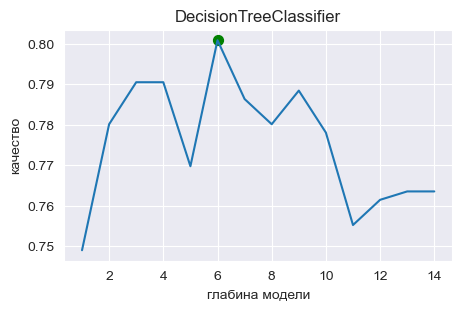

Лучший результат accuracy_score 80.08%
Глубина дерева лучшего результата равна 6


In [13]:
# модель дерево решений
# параметры подобраны в ручную кроме высоты дерева
result_list_DT = []
best_model_DT = None
best_result = 0

for depth in range(1, 15):
    model =(DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=8,
                                   criterion='gini', splitter='best', min_samples_split=8)) # обучим модель с заданной глубиной дерева
    model.fit(X_train, y_train) 
    predictions = model.predict(X_valid) # получили предсказания модели
    result = accuracy_score(y_valid, predictions) # посчитали качество модели
    result_list_DT.append(result)
    if result > best_result:
        max_depth = depth
        best_model_DT = model
        best_result = result

final_result['DecisionTreeClassifier'].append(best_result)
        
sns.set_style("darkgrid")  
plt.figure(figsize=(5,3))
sns.lineplot(pd.Series(result_list_DT, index=np.arange(1,15))).set(title='DecisionTreeClassifier');
plt.scatter(x=[max_depth], y=[best_result], color='green', s=50, marker='o')
ax = plt.subplot()
ax.set(xlabel='глабина модели', ylabel='качество')
plt.show()

print(f'Лучший результат accuracy_score {best_result:,.2%}')
print(f'Глубина дерева лучшего результата равна {max_depth}')


In [14]:
final_result

{'DecisionTreeClassifier': [0.8008298755186722],
 'RandomForestClassifier': [],
 'LogisticRegression': []}

### RandomForestClassifier 
для подбора гиперпараметров воспользуемся методом RandomizedSearchCV

In [15]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [16]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(2, 120, 3, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 8, 10, 14],
               'n_estimators': list(np.linspace(5, 120, 5, dtype = int))}

clf = RandomForestClassifier();

model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 0, random_state= 12345, n_jobs = -1)


model.fit(X_train,y_train)
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=61, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=8,
                       n_estimators=120)

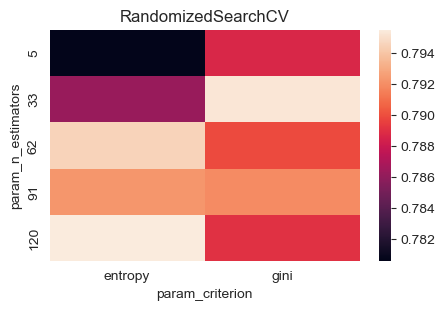

In [17]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')

plt.figure(figsize=(5,3))     
sns.heatmap(table).set(title='RandomizedSearchCV');


In [18]:
model = (RandomForestClassifier(random_state=12345, max_depth=120, max_features='sqrt', 
                                min_samples_leaf=8, min_samples_split=5, n_estimators=91, criterion='entropy')) 
model.fit(X_train,y_train)
result = model.score(X_valid, y_valid)
print(f'Результат применения метода RandomForestClassifier {result:,.3%}')

Результат применения метода RandomForestClassifier 79.668%


In [19]:
model = (RandomForestClassifier(random_state=12345, max_depth=120, max_features='sqrt', 
                                min_samples_leaf=8, min_samples_split=8, n_estimators=120, criterion='gini')) 
model.fit(X_train,y_train)
result = model.score(X_valid, y_valid)
print(f'Результат применения метода RandomForestClassifier {result:,.3%}')

Результат применения метода RandomForestClassifier 79.876%


In [20]:
# модель с заданным количеством деревьев
# экспериментально было установлено, что после 100 деревьев качество 
# модели не меняется наглядно демонстрируя закон больших чисел
result_list_FD = []
best_model_FD = None
best_result = 0

for est in range(1, 100):
    model = (RandomForestClassifier(random_state=12345, n_estimators=est, 
                                    criterion='gini',  max_depth=6, min_samples_leaf=8, 
                                    min_samples_split=8)) 
    model.fit(X_train, y_train) # модель на тренировочной выборке
    result = model.score(X_valid, y_valid) # качество модели на валидационной выборке
    result_list_FD.append(result)
    if result > best_result:
        number_est = est
        best_model_FD = model   # лучшая модель
        best_result = result # наилучшее значение метрики accuracy на валидационных данных
 
final_result['RandomForestClassifier'].append(best_result)

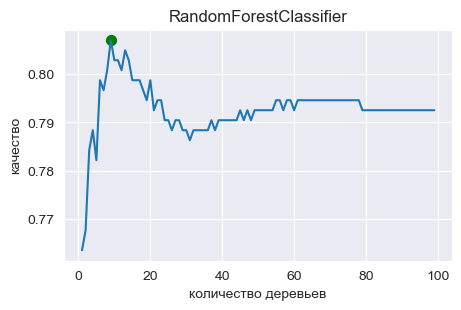

Лучший результат accuracy_score 80.71%
Лучшее качество модели с количеством деревьев 9


In [21]:
sns.set_style("darkgrid")  
plt.figure(figsize=(5,3))
sns.lineplot(pd.Series(result_list_FD, index=np.arange(1,100))).set(title='RandomForestClassifier');
plt.scatter(x=[number_est], y=[best_result], color='green', s=50, marker='o')
ax = plt.subplot()
ax.set(xlabel='количество деревьев', ylabel='качество')
plt.show()

print(f'Лучший результат accuracy_score {best_result:,.2%}')
print(f'Лучшее качество модели с количеством деревьев {number_est}')

### LogisticRegression

In [22]:
param_grid = ({'C':[0.2, 0.4, 0.8, 1.6, 3.2],'solver' : ['lbfgs'], 'max_iter' : [10000]})

clf = (GridSearchCV(LogisticRegression(random_state = 12345), param_grid, cv = 5, verbose = 0, n_jobs = -1))

best_model = clf.fit(X_train, y_train)
print(best_model.best_estimator_)

result = best_model.score(X_valid, y_valid)
print(f'Лучший результат accuracy_score {result:,.2%}')

final_result['LogisticRegression'].append(result)

LogisticRegression(C=0.4, max_iter=10000, random_state=12345)
Лучший результат accuracy_score 73.44%


In [23]:
for i in final_result:
    print('Качество модели {} составляет {:,.2%}'.format(i, *final_result[i]))

Качество модели DecisionTreeClassifier составляет 80.08%
Качество модели RandomForestClassifier составляет 80.71%
Качество модели LogisticRegression составляет 73.44%


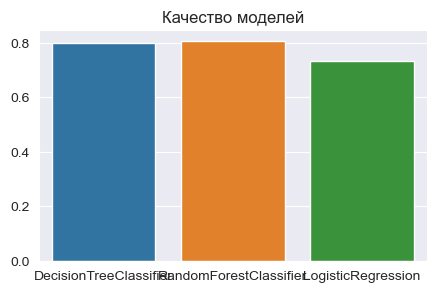

In [24]:
final_result = pd.DataFrame(final_result)
plt.figure(figsize=(5,3));
sns.barplot(final_result).set(title='Качество моделей');

plt.show()

### Вывод
Модель классификации RandomForestClassifier показала лучшие показатели с результатом 80.71% <br>
и количеством деревьев равное 9<br>

Модель DecisionTreeClassifier справилась с с показателем 80.08% <br>
и глубиной дерева равной 6<br>

LogisticRegression показала худший результат с показателем 73.44% <br>

## Проверьте модель на тестовой выборке

In [25]:
result_DT = best_model_DT.score(X_test, y_test)# DecisionTreeClassifier 
result_FD = best_model_FD.score(X_test, y_test) # RandomForestClassifier
result = best_model.score(X_test, y_test) # LogisticRegression


print(f'Качество модели DecisionTreeClassifier равно {result_DT:,.2%}')
print(f'Качество модели RandomForestClassifier равно {result_FD:,.2%}')
print(f'Качество модели LogisticRegression равно {result:,.2%}')

Качество модели DecisionTreeClassifier равно 80.95%
Качество модели RandomForestClassifier равно 82.82%
Качество модели LogisticRegression равно 74.95%


### Вывод
Проверка моделей на тестовой выборке показала результат немного лучше, чем на <br>
валидационной выборке<br>

## (бонус) Проверьте модели на адекватность

In [26]:
import random

random_predictions = np.random.randint(low = 0, high = 2, size = len(X_test)) 
bonus_result = accuracy_score(y_test, random_predictions)
bonus_result

print(f'Вероятность случайного правельного ответа равна {bonus_result:,.2%}')

Вероятность случайного правельного ответа равна 47.41%


### Вывод
Все модели классификации обученные нами показали результат, значительно, выше случайного<br>
Подтвердив свою адекватность <br>

## Вывод финал

Цель достигнута <br>
Модель построеная с использованием RandomForestClassifier "best_model_FD" рекомендуем <br>
Для использования при классификации пользователей "Мегалайн" и рекомендации новых <br>
Тарифов «Ультра» и «Смарт» <br>
Точность модели 82.82%<br>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
